1) Read the images and generate the train and test dataset (10 points)

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [2]:
TRAin_DATA_FOLDER= "train"

In [3]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        classes.append(class_label)

In [4]:
len(images)

4179

In [5]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [6]:
images = [resize_images(img) for img in images]

In [7]:
images[0].shape

(256, 256, 3)

In [8]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4179, 256, 256, 3)
classes shape:  (4179,)
number of Maize images is  -> 221
number of Small-flowered Cranesbill images is  -> 496
number of Cleavers images is  -> 287
number of Charlock images is  -> 390
number of Shepherds Purse images is  -> 231
number of Common Chickweed images is  -> 261
number of Sugar beet images is  -> 385
number of Black-grass images is  -> 263
number of Loose Silky-bent images is  -> 654
number of Fat Hen images is  -> 475
number of Scentless Mayweed images is  -> 516


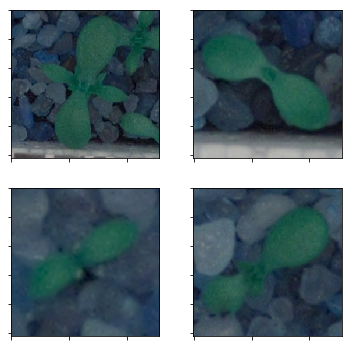

In [9]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

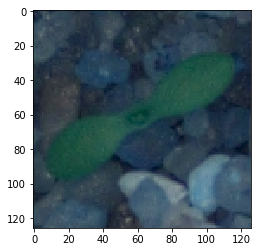

In [10]:
img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")
plt.imshow(img)

In [11]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [12]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [13]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

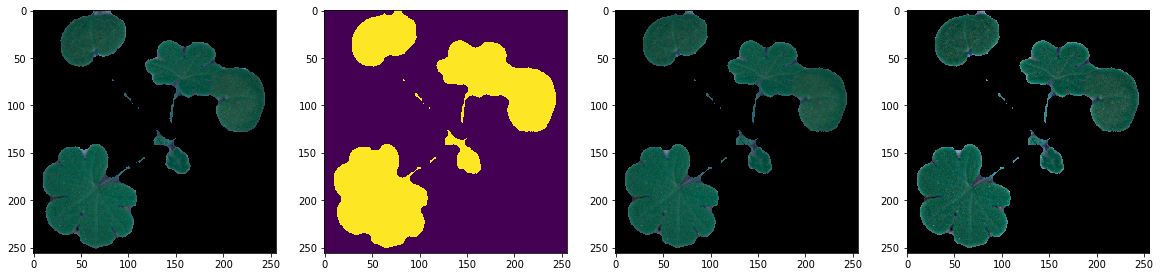

In [14]:
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

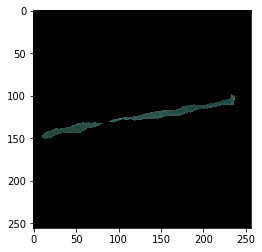

In [15]:
plt.imshow(images[0])

In [16]:
images.shape

(4179, 256, 256, 3)

In [17]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [18]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2) Divide the data set into Train and validation data sets

In [19]:
#Creating train test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_train.shape

(2925, 256, 256, 3)

In [20]:
#Creating validation set
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [21]:
print(X_test.shape)
print(X_val.shape)

(627, 256, 256, 3)
(627, 256, 256, 3)


3) Initialize & build the model (20 points)

In [22]:

import tensorflow as tf
# Set the CNN model 

batch_size = 3

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))


model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.4))



model.add(tf.keras.layers.GlobalMaxPooling2D())
model.add(tf.keras.layers.Dense(256, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(11, activation = "softmax"))
model.summary()

W1004 11:42:27.285225  2152 deprecation.py:506] From C:\Users\Public\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (3, 256, 256, 32)         2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (3, 256, 256, 32)         25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (3, 128, 128, 32)         0         
_________________________________________________________________
dropout (Dropout)            (3, 128, 128, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (3, 128, 128, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (3, 128, 128, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (3, 64, 64, 64)           0

4) Optimize the model (16 points)

In [23]:
opt = tf.keras.optimizers.Adam(lr=0.001)

#optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

5) Predict the accuracy for both train and validation data (14 points)

In [24]:
model.fit(X_train, y_train, epochs = 50, validation_data = (X_val,Y_val),batch_size = batch_size)

Train on 2925 samples, validate on 627 samples
Epoch 1/50
2925/2925 [==============================] - 212s 73ms/sample - loss: 2.4498 - acc: 0.1456 - val_loss: 2.2825 - val_acc: 0.1531
Epoch 2/50
2925/2925 [==============================] - 194s 66ms/sample - loss: 2.2900 - acc: 0.1740 - val_loss: 2.2774 - val_acc: 0.2073
Epoch 3/50
2925/2925 [==============================] - 198s 68ms/sample - loss: 2.2564 - acc: 0.1986 - val_loss: 2.2163 - val_acc: 0.2408
Epoch 4/50
2925/2925 [==============================] - 203s 69ms/sample - loss: 2.2574 - acc: 0.2003 - val_loss: 2.2466 - val_acc: 0.2137
Epoch 5/50
2925/2925 [==============================] - 219s 75ms/sample - loss: 2.1646 - acc: 0.2188 - val_loss: 2.2224 - val_acc: 0.2010
Epoch 6/50
2925/2925 [==============================] - 258s 88ms/sample - loss: 2.2516 - acc: 0.1976 - val_loss: 2.2309 - val_acc: 0.2137
Epoch 7/50
2925/2925 [==============================] - 288s 98ms/sample - loss: 2.2189 - acc: 0.2000 - val_loss: 2.248

In [25]:
print(tf.__version__)

1.14.0


In [26]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [27]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.519273809411309
Test accuracy: 0.46889952
